In [3]:
import os
import shelve

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import EMB

In [11]:
# 1 Generate duplex
G = EMB.netsci.models.benchmarks.generate_network_LFR(
        1000, 2.1, 1.0, 0.1, 6, 32, 1, os.path.join("..", "..", "")
)[0]
H = EMB.netsci.models.benchmarks.generate_network_LFR(
        1000, 2.1, 1.0, 0.1, 20, 32, 1, os.path.join("..", "..", "")
)[0]

D = dict(enumerate(EMB.netsci.models.preprocessing.make_layers_disjoint(G, H)))
print(G.number_of_edges() / H.number_of_edges())

0.321751968503937


In [12]:
# 1.5 Instantiate records
records = {}

In [13]:
for theta in tqdm_notebook(np.linspace(0.05, 0.95, 19)):
    # 2 Observe remnants
    remnant_multiplex = EMB.remnants.observer.random_observations_multiplex(D, theta)
    remnant_multiplex = EMB.remnants.observer.build_remnant_multiplex(D, remnant_multiplex)

    # 3 Embed multiplex
    vectors = EMB.embeddings.embed_multiplex_N2V(remnant_multiplex, dimensions=128)

    # 4 Calculate features
    testing_edges = remnant_multiplex[-1].edges()
    training_edges = EMB.netsci.all_edges(*remnant_multiplex.values()) - set(testing_edges)
    y_train = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in training_edges}
    y_test = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in testing_edges}
    remnant_multiplex = EMB.utils.cutkey(remnant_multiplex, -1)
    components = {
        label: sorted(nx.connected_components(graph))
        for label, graph in remnant_multiplex.items()
    }
    vectors = EMB.utils.cutkey(vectors, -1)
    for label, vectorset in vectors.items():
        node2id = dict()
        vectors[label] = EMB.embeddings.normalize_vectors(vectorset, components[label], node2id=node2id)
    training_distances = EMB.classifiers.get_distances_feature(vectors.values(), training_edges, training=True)
    testing_distances = EMB.classifiers.get_distances_feature(vectors.values(), testing_edges, training=False)
    training_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), training_edges, training=True)
    testing_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), testing_edges, training=False)
    X_train = np.array([training_distances, training_degrees]).transpose()
    X_test = np.array([testing_distances, testing_degrees]).transpose()

    # 5 Train model
    model = EMB.classifiers.train_model(X_train, list(y_train.values()))

    # 6 Evaluate model
    accuracy, auroc, pr = EMB.classifiers.evaluate_model(model, X_test, list(y_test.values()))

    # 7 Add evaluation to records
    records[theta] = (accuracy, auroc, pr)

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
with shelve.open('records_imbalanced.shelf') as shelf:
    shelf['N2V'] = records

In [4]:
with shelve.open('records_imbalanced.shelf') as shelf:
    records = shelf['N2V']

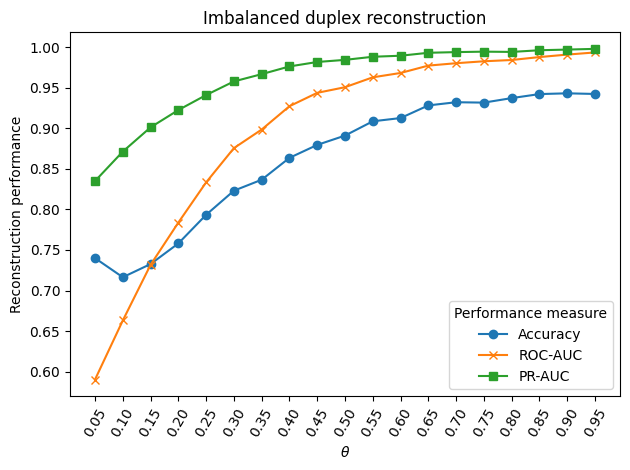

In [5]:
plt.figure()

x = sorted(records.keys())
accuracy = [x[0] for x in records.values()]
auroc = [x[1] for x in records.values()]
pr = [x[2] for x in records.values()]

plt.plot(
    x, accuracy,
    label="Accuracy",
    marker="o")
plt.plot(
    x, auroc,
    label="ROC-AUC",
    marker="x")
plt.plot(
    x, pr,
    label="PR-AUC",
    marker="s")
plt.legend(title="Performance measure")

plt.xticks(x, rotation=60)
plt.xlabel(r"$\theta$")
plt.ylabel("Reconstruction performance")

plt.title("Imbalanced duplex reconstruction")
plt.tight_layout()
plt.savefig(os.path.join("..", "..", "results", "figures", "figure_perf-auroc_hue-perftype_data-imbalanced-LFR.png"), transparent=False, facecolor="white")